<a href="https://www.youtube.com/watch?v=SmWbKiueYVU&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=12"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link to my YouTube Video - Topic Modeling with BERT base Sentence transformer Model and implementing Automatic Cluster Labeling</b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/5E3UXE4.png)](https://www.youtube.com/watch?v=SmWbKiueYVU&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=12 "Topic Modeling with BERT base Sentence transformer Model and implementing Automatic Cluster Labeling")


-----------------

## [Dataset Link](https://zenodo.org/record/1000885#.YxxQ7NJBxhF)

In [58]:
import numpy as np 
import pandas as pd 
import random as rn
import re
import nltk
import os

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from nltk.corpus import stopwords
from wordcloud import WordCloud

import umap # dimensionality reduction
import hdbscan # clustering
from functools import partial

# To perform the Bayesian Optimization for searching the optimum hyperparameters, 
# we use hyperopt package:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

/home/paul/.local/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
rn.seed(a=42)

p = 0.004  # to randomly select 0.4% of the rows

df_reviews = pd.read_csv('../input/steam-reviews/dataset.csv', skiprows=lambda i: i>0 and rn.random() > p)

# size of dataframe
print(df_reviews.shape)
# display the head of data
display(df_reviews.head())

(25435, 5)


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,Hands down the GOAT.,1,1
2,10,Counter-Strike,good game visit my gorup and play on my cs server http://steamcommunity.com/groups/yuugaming,1,0
3,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
4,10,Counter-Strike,"Well if you think ♥♥♥♥♥♥ game,♥♥♥♥♥♥ graphics,♥♥♥♥♥iy weapons,you are a very crazy person.This game yes its an ♥♥♥♥♥♥ Game but its fun so no give any crap.Don't buy it on 9.99 dolars buy it on when sales like 2.49 and 4.99 dolars.Great game for relax.Recommending!",1,0


<AxesSubplot:xlabel='review_score', ylabel='count'>

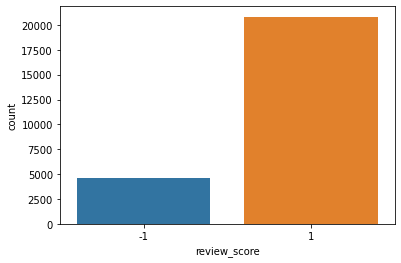

In [3]:
sns.countplot(x = 'review_score', data = df_reviews)

In [4]:
df_reviews['review_text'] = df_reviews['review_text'].astype(str)
df_reviews['review_votes'] = df_reviews['review_votes'].astype(str)

df_reviews.review_text = df_reviews.review_text.apply(lambda s : s.strip())

df_reviews_2 = df_reviews[df_reviews['review_score'].notnull()]

df_reviews_2['review_score'] = np.where(df_reviews_2['review_score'] == -1, 0, df_reviews_2['review_score'])

df_reviews_2.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,Hands down the GOAT.,1,1
2,10,Counter-Strike,good game visit my gorup and play on my cs server http://steamcommunity.com/groups/yuugaming,1,0
3,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
4,10,Counter-Strike,"Well if you think ♥♥♥♥♥♥ game,♥♥♥♥♥♥ graphics,♥♥♥♥♥iy weapons,you are a very crazy person.This game yes its an ♥♥♥♥♥♥ Game but its fun so no give any crap.Don't buy it on 9.99 dolars buy it on when sales like 2.49 and 4.99 dolars.Great game for relax.Recommending!",1,0


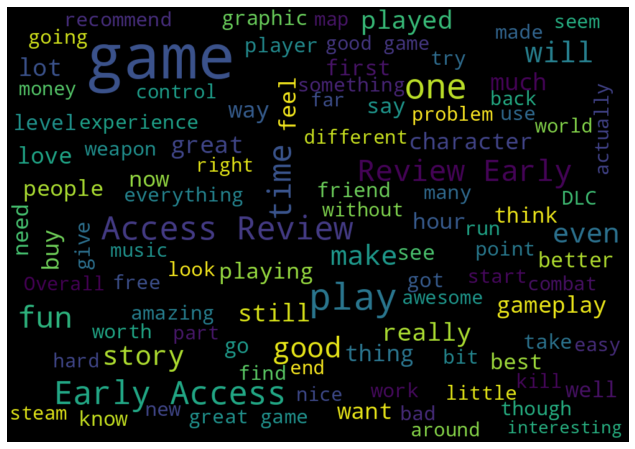

In [5]:
txt = ' '.join(rev for rev in df_reviews_2.review_text )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100, 
    width=1000, 
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

In [6]:
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != 'Early Access Review']

df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]



df_reviews_2.drop_duplicates(['review_text', 'review_score' ], inplace = True )

print(df_reviews_2.shape)

(21197, 5)


In [7]:
df_reviews_2.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,Hands down the GOAT.,1,1
2,10,Counter-Strike,good game visit my gorup and play on my cs server http://steamcommunity.com/groups/yuugaming,1,0
3,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
4,10,Counter-Strike,"Well if you think ♥♥♥♥♥♥ game,♥♥♥♥♥♥ graphics,♥♥♥♥♥iy weapons,you are a very crazy person.This game yes its an ♥♥♥♥♥♥ Game but its fun so no give any crap.Don't buy it on 9.99 dolars buy it on when sales like 2.49 and 4.99 dolars.Great game for relax.Recommending!",1,0


In [8]:
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)

# df_reviews_2['review_text_clean'] = df_reviews_2.review_text.apply(replace_hearts_with_PAD)

# df_reviews_2.head()

## Function to remove emoji

In [9]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

## Clean some basic characters

In [10]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

## Remove numeric

In [11]:
def remove_num(texts):
    output = re.sub(r'\d+', '', texts )
    return output

##  function to unify whitespaces

In [12]:
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text )
    return cleaned_string

## function to remove punctuation

In [13]:
def remove_punctuation(text):
    result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',',') )
    return result

## remove stopwords

In [14]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop ]
    return ' '.join(text)

[nltk_data] Downloading package stopwords to /home/paul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## function to use stemming to normalize words

In [15]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def Stemming(text):
    stem = []
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [ snowball_stemmer.stem(word) for word in word_tokens ]
    stem = ' '.join(stemmed_word)
    return stem

## Aplying all the cleaning util methods

In [16]:
def cleaning(df, review):
    df_processed = df.copy()
    df_processed[review] = df_processed['review_text']
    df_processed[review] = df_processed[review].apply(clean)
    df_processed[review] = df_processed[review].apply(deEmojify)
    df_processed[review] = df_processed[review].apply(replace_hearts_with_PAD)
    df_processed[review] = df_processed[review].apply(remove_num)
    df_processed[review] = df_processed[review].apply(remove_punctuation)
    df_processed[review] = df_processed[review].apply(remove_stopwords)
    df_processed[review] = df_processed[review].apply(unify_whitespaces)
    df_processed[review] = df_processed[review].apply(Stemming)
    return df_processed

df_processed = cleaning(df_reviews_2, 'review_text_clean' )

In [17]:
df_processed.head()

,app_id,app_name,review_text,review_score,review_votes,review_text_clean
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1,score say there 's anoth version call counter-strik sourc noth compar origin counter-strik plus aday realli realli cheap like dollar steam well like biggest competit game communiti world hundr thousand dollar worth tournament player etc good stuff
1,10,Counter-Strike,Hands down the GOAT.,1,1,hand goat
2,10,Counter-Strike,good game visit my gorup and play on my cs server http://steamcommunity.com/groups/yuugaming,1,0,good game visit gorup play cs server http//steamcommunitycom/groups/yuugam
3,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0,realli like game couldn ’ t find stupid cake
4,10,Counter-Strike,"Well if you think ♥♥♥♥♥♥ game,♥♥♥♥♥♥ graphics,♥♥♥♥♥iy weapons,you are a very crazy person.This game yes its an ♥♥♥♥♥♥ Game but its fun so no give any crap.Don't buy it on 9.99 dolars buy it on when sales like 2.49 and 4.99 dolars.Great game for relax.Recommending!",1,0,well think * * * * game * * * * graphic * * * * iy weaponsyou crazi personthi game yes * * * * game fun give crapdo n't buy dolar buy sale like dolarsgreat game relaxrecommend


In [18]:
neg_reviews = df_processed[df_processed.review_score == 0]

neg_reviews = neg_reviews.sample(n = 2000, random_state=1234)

all_intents = neg_reviews.review_text_clean.tolist()

print(neg_reviews.shape)

(2000, 6)


In [19]:
neg_reviews.head()

,app_id,app_name,review_text,review_score,review_votes,review_text_clean
4935,219740,Don't Starve,This is a fun game for a small amount of time unless you are a no lifer . I don't mean that as an insult to anyone it's just some people have more time than others ..like anyone with a job or kids or literally anything to do other than play video games will not have time for this game . I made the mistake of playing way to many hours only to never get past a few weeks because this game explain...,0,0,fun game small amount time unless lifer mean insult anyon peopl time other like anyon job kid liter anyth play video game time game made mistak play way mani hour never get past week game explain noth start understand go read/watch guid even could random bad luck like spawn world row rain none stop froze death spawn summer die heat within minut game even tell take damag read guid hey im glad p...
22189,443580,Antenna,Games looks nice but it has slow pace even for an adventure.,0,0,game look nice slow pace even adventur
13426,280,Half-Life: Source,"As 'Good' a this remake sounds, its still just the original Half-Life reworked in source minus the excellent graphics of source. Now im not saying that this game is bad but i am saying that its inferior to the original thats available on steam. The reason I say that is because unlike Half-life Half-Life:Source does not include HD mode. (HD mode is basically the original HD Pack included with t...",0,0,good ' remak sound still origin half-lif rework sourc minus excel graphic sourc im say game bad say inferior origin that avail steam reason say unlik half-lif half-lifesourc includ hd mode ( hd mode basic origin hd pack includ releas blueshift made npcs weapon look consider better ) real advantag half-lif sourc origin stabl engin ( not say there anyth wrong gold sourc engin ) get rid glitch or...
13312,275850,No Man's Sky,Don't buy this game. That is all.,0,0,buy game
919,11180,Sherlock Holmes: The Mystery of The Persian Carpet,"There are many great Sherlock Holmes games created by Frogwares, Jack the Ripper, The Awakened, Nemisis, etc. But this game, Sherlock Holmes and The Persian Carpet is nothing like any of those. Though there are some good points in this game, there are numerous bad ones. I would like to be able to comment on the storyline in the game, but I was too distracted by the terrible gameplay to even n...",0,0,mani great sherlock holm game creat frogwar jack ripper awaken nemisi etc game sherlock holm persian carpet noth like though good point game numer bad one would like abl comment storylin game distract terribl gameplay even notic happen storylin even crucial complet game deduct board put clue togeth stori noth mere connect one object anoth three differ mode play first causal mode ' mode perfect...


In [ ]:
# all_intents

In [21]:
all_sents = []

for intent in all_intents:
    for sent in nltk.sent_tokenize(intent):
        if len(sent.split()) > 4:
            all_sents.append(sent)

print(len(all_sents))

all_intent = all_sents

1794


# Sentence Embedding

In [22]:
from sentence_transformers import SentenceTransformer
import tensorflow as tf

In [23]:
def embed(model, model_type, sentences ):
    if model_type == 'use':
        embeddings  = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
        
    return embeddings
        
model_st1 = SentenceTransformer('all-mpnet-base-v2', device='cpu' )

embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents )

In [24]:
embeddings_st1.shape

(2000, 768)

## Dimensionality Reduction

![](2022-09-11-21-43-10.png)

# Use Bayesian Optimization with Hyperopt

Following are four common methods of hyperparameter optimization for machine learning in order of increasing efficiency:

Manual

Grid search

Random search

Bayesian model-based optimization


The one-sentence summary of Bayesian hyperparameter optimization is: build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

In [25]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,32)),
    "n_components": hp.choice('n_components', range(3,32)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,32)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 25 # change it to 50 or 100 for extra steps as you wish.

In [26]:
# import importlib
# importlib.reload(utils)


In [27]:
%%time
from utils import *
best_params_use, best_clusters_use, trials_use = utils.bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 25/25 [04:14<00:00, 10.18s/trial, best loss: 0.4355]
best:
{'min_cluster_size': 6, 'n_components': 23, 'n_neighbors': 6, 'random_state': 42}
label count: 61
CPU times: user 4min 40s, sys: 11.6 s, total: 4min 52s
Wall time: 4min 23s


In [40]:
data_clustered = pd.DataFrame(data = list(zip(all_intents, best_clusters_use.labels_ )) , columns=['text', 'label_st1' ] )

data_clustered.head(10)

,text,label_st1
0,fun game small amount time unless lifer mean insult anyon peopl time other like anyon job kid liter anyth play video game time game made mistak play way mani hour never get past week game explain noth start understand go read/watch guid even could random bad luck like spawn world row rain none stop froze death spawn summer die heat within minut game even tell take damag read guid hey im glad p...,39
1,game look nice slow pace even adventur,13
2,good ' remak sound still origin half-lif rework sourc minus excel graphic sourc im say game bad say inferior origin that avail steam reason say unlik half-lif half-lifesourc includ hd mode ( hd mode basic origin hd pack includ releas blueshift made npcs weapon look consider better ) real advantag half-lif sourc origin stabl engin ( not say there anyth wrong gold sourc engin ) get rid glitch or...,-1
3,buy game,35
4,mani great sherlock holm game creat frogwar jack ripper awaken nemisi etc game sherlock holm persian carpet noth like though good point game numer bad one would like abl comment storylin game distract terribl gameplay even notic happen storylin even crucial complet game deduct board put clue togeth stori noth mere connect one object anoth three differ mode play first causal mode ' mode perfect...,52
5,use lot fun play game age grace ugh,-1
6,troll develop,-1
7,game interest tower defens mechan primit bore gameplay cool theme,6
8,want zombi surviv game buy dayz,-1
9,full twelv year old spammer time waister cours drop out start game like game alot player * * * * immposs get game togeth without spam cuss leav game report noth develop joke want money take action keep claim im fed crap someth game hard find decent game good develop priceybut get pay ehh,-1


In [43]:
del C_

In [41]:
best_clusters_use.labels_

array([39, 13, -1, ..., -1, 44, 31])

# Automatic cluster labeling

In [50]:
data_clustered = pd.DataFrame(data = list(zip(all_intents, best_clusters_use.labels_ )) , columns=['text', 'label_st1' ] )

data_clustered.head()

,text,label_st1
0,fun game small amount time unless lifer mean insult anyon peopl time other like anyon job kid liter anyth play video game time game made mistak play way mani hour never get past week game explain noth start understand go read/watch guid even could random bad luck like spawn world row rain none stop froze death spawn summer die heat within minut game even tell take damag read guid hey im glad p...,39
1,game look nice slow pace even adventur,13
2,good ' remak sound still origin half-lif rework sourc minus excel graphic sourc im say game bad say inferior origin that avail steam reason say unlik half-lif half-lifesourc includ hd mode ( hd mode basic origin hd pack includ releas blueshift made npcs weapon look consider better ) real advantag half-lif sourc origin stabl engin ( not say there anyth wrong gold sourc engin ) get rid glitch or...,-1
3,buy game,35
4,mani great sherlock holm game creat frogwar jack ripper awaken nemisi etc game sherlock holm persian carpet noth like though good point game numer bad one would like abl comment storylin game distract terribl gameplay even notic happen storylin even crucial complet game deduct board put clue togeth stori noth mere connect one object anoth three differ mode play first causal mode ' mode perfect...,52


In [51]:
example_category = data_clustered[data_clustered['label_st1'] == 24 ].reset_index(drop = True)
example_category.head()

,text,label_st1
0,game suck feel bad peopl paid,24
1,match engin bad i 'm forc play footbal direct toni puli sam allardyc combin noth stabl game plan apart get wide cross good game match engin look clean everyth nice tidi,24
2,complet unfair pay win download free pay money hitmark system take entir screen gun except paid one sniper aim sight millisecond anyon qucikscop match make rank base even suck stuck beast pay win tri hard fun - game,24
3,decid hop hate train lucki someon pay penni sod add co-op gon na charg anoth buck use,24
4,surpris lack featur function compar first game avoid cost,24


## Find the IDF (inverse document frequency) of every word

Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where t is the term (word) we are looking to measure the commonness of and N is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, t, appears in. 

![](2022-09-14-02-32-13.png)

In [52]:
from collections import Counter

sent_with_word_lemma = []

for intent in all_intents:
    doc = nlp(intent)
    temp_sentence = ""
    this_one = False
    for token in doc:
        if (token.pos_ in ['VERB', 'NOUN', 'ADJ'] or (token.dep_ == 'dobj' ) ):
            temp_sentence += token.lemma_.lower() + " "
    sent_with_word_lemma.append(temp_sentence)
    

In [53]:
sent_with_word_lemma[:3]

['fun game small amount time lifer mean anyon peopl time other anyon job kid play video game time game make mistak play way hour get past week game explain start go read watch guid bad luck world row rain none stop freeze death spawn summer die heat minut game tell take damag read guid m glad peopl game consid hardcor gamer avoid time sink ',
 'game look nice slow pace adventur ',
 'good remak sound origin half lif rework sourc graphic m say game bad say inferior origin avail steam reason say unlik half lif half lifesourc includ hd mode mode basic origin hd blueshift make weapon look consider advantag half lif sourc origin stabl engin say wrong gold sourc engin rid glitch origin end half lif much improv origin half lif actual think blurri person opinion ']

In [54]:
def compute_IDF(documents):
    """
    Computes the IDF (Inverse Document Frequency) values for words in a collection of documents.

    Args:
        documents (List[str]): List of documents.

    Returns:
        dict: Dictionary mapping words to their IDF values.

    """
    word_count = Counter()
    for doc in documents:
        if 'drops(players' in doc:
            print(doc)
        word_set = set(doc.split())
        word_count.update(word_set)
    # print(word_count)
    total = sum(word_count.values())
    word_IDF = {k : round(( np.log2(total / v ) )) for k, v in word_count.items() }
    return word_IDF

word_IDF = compute_IDF(sent_with_word_lemma)
word_IDF
        

{'job': 11,
 'other': 10,
 'death': 11,
 'mistak': 12,
 'get': 6,
 'glad': 12,
 'minut': 9,
 'time': 7,
 'explain': 12,
 'past': 11,
 'rain': 14,
 'peopl': 9,
 'sink': 13,
 'way': 8,
 'freeze': 14,
 'hour': 8,
 'lifer': 16,
 'heat': 15,
 'week': 11,
 'watch': 10,
 'bad': 7,
 'small': 10,
 'consid': 11,
 'read': 10,
 'spawn': 12,
 'amount': 10,
 'go': 7,
 'kid': 11,
 'stop': 10,
 'game': 5,
 'make': 7,
 'play': 6,
 'start': 8,
 'hardcor': 12,
 'luck': 11,
 'damag': 11,
 'fun': 8,
 'none': 11,
 'die': 10,
 'video': 10,
 'guid': 13,
 'row': 13,
 'm': 9,
 'anyon': 10,
 'world': 9,
 'summer': 14,
 'take': 8,
 'gamer': 11,
 'avoid': 10,
 'mean': 9,
 'tell': 9,
 'slow': 10,
 'adventur': 12,
 'pace': 13,
 'look': 8,
 'nice': 9,
 'origin': 10,
 'inferior': 14,
 'good': 7,
 'engin': 11,
 'much': 8,
 'person': 9,
 'consider': 13,
 'mode': 10,
 'think': 8,
 'blueshift': 16,
 'advantag': 13,
 'end': 9,
 'improv': 12,
 'avail': 11,
 'hd': 13,
 'graphic': 9,
 'remak': 13,
 'wrong': 10,
 'lif': 14,
 '

# Automatic cluster labeling


### Here we’ll concatenate the most common verb, direct object, and top two nouns from each cluster for our Automatic cluster labeling.


In [65]:
def get_group(df, category_col, category ):
    """
    The get_group function takes a DataFrame (df), a category column name (category_col), and a category value (category) as inputs. It filters the DataFrame based on the specified category and returns a subset of the DataFrame containing only the rows with that category.

    Args:
        df (pd.DataFrame): DataFrame to filter.
        category_col (str): Name of the column containing the category.
        category: Category value to filter on.

    Returns:
        pd.DataFrame: Subset of the DataFrame with the specified category.

    """
    single_category = df[df[category_col] == category ].reset_index(drop = True)
    return single_category


def most_common(lst, n_words ):
    """
    This function takes a list of words (lst) and the number of top common words to return (n_words). It uses the collections.Counter class to count the occurrences of each word in the list. If a word appears more than once (counter[k] > 1), it multiplies its count by the corresponding IDF value (word_IDF[k]). Finally, the function returns a list of tuples representing the n most common words and their counts, obtained using the counter.most_common(n_words) method.
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter = collections.Counter(lst)
    for k in list(counter):
        if counter[k] == 1:
            pass
        else:
            counter[k] *= word_IDF[k]
            
    return counter.most_common(n_words)

In [71]:
def extract_labels(category_doc, print_word_counts = False):
    ''' 
    Argument:
        category_docs: list of documents, all from the same category or clustering. category_docs is a list of strings like below 
        ['fun game small amount time unless lifer..........', ....  'steem pile graphic' ]
        
        print_word_counts: bool, True will print word counts of each type in this category
    '''
    
    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''
    
    for i in range(len(category_doc)):
        doc = nlp(category_doc[i])
        for token in doc:
            if (token.is_stop == False ) and (len(str(token).strip()) >0 ):
                if token.pos_ == 'VERB':
                    verbs.extend([token.lemma_.lower()])
                
                elif token.dep_ == 'dobj':
                    dobjs.extend([token.lemma_.lower()])
                    
                elif token.pos_ == 'NOUN':
                    nouns.extend([token.lemma_.lower()])
                    
                elif token.pos_ == 'ADJ':
                    adjs.extend([token.lemma_.lower()])
                    
    
    # print('most_common(verbs, 1) ', most_common(verbs, 1))
    # [('m', 27)]
    
    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter = collections.Counter(word_lst)
            print(counter)
            
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
        
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
        
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
        
        
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
            
    if '' in label_words:
        label_words.remove('')
        
    label = '_'.join(label_words)
    
    return label          
                    
        
        

In [72]:
current_cat = ['fun game small amount time unless lifer mean insult anyon peopl time other like anyon job kid liter anyth play video game time game made mistak play way mani hour never get past week game explain noth start understand go read watch guid even could random bad luck like spawn world row rain none stop froze death spawn summer die heat within minut game even tell take damag read guid hey im glad peopl like game unless consid hardcor gamer would avoid time sink', 'game look nice slow pace even adventur', 'good remak sound still origin half life rework sourc minus excel graphic sourc im say game bad say inferior origin that avail steam reason say unlik half life half life sourc includ hd mode hd mode basic origin hd pack includ releas blueshift made npcs weapon look consider better real advantag half life sourc origin stabl engin say there anyth wrong gold sourc engin get rid glitch origin end half life sourc realli isnt much improv origin half life improv ps actual think graphic blurri person opinion', 'game interest tower defens mechan primit bore gameplay cool theme', 'want zombi surviv game buy dayz', 'full twelv year old spammer time waister cours drop out start game like game alot player immposs get game togeth without spam cuss leav game report noth develop joke want money take action keep claim im fed crap someth game hard find decent game good develop priceybut get pay ehh', 'find wait line forev join battl rare final get spot join battl actual pretti fun good game play want give wait forev', 'gta iv fantast game stori onlin great reconmen game issu run modern hardwar window run window might alright might issu', 'steem pile graphic' ]


x = extract_labels(current_cat)
x

'm_time_game_life'

In [75]:
list(get_group(data_clustered, 'label_st1', 18 )['text'])

['tire bad ai bad unit collis diplomaci',
 'easi die play game',
 'buggi pain play seri much potenti wast',
 "activ mod ' communiti",
 'suuuuck * bleeeugh yeeeeuch *',
 'rubbish game squeez franchis dri mind stori game play terribl physic forth best avoid',
 'short generic dark skip bad wast potenti',
 'artifici difficulti',
 'u beefalo / # iwantmorebeefalo',
 'may caus braindamgrsdsdfhbn l',
 'pretenti piec irrit garbag',
 'w # nk',
 'great potenti ruin idiot balanc economi decis',
 'stori kill enemi + dat mous sensit kill',
 '% franchais fake run away caus ac',
 'alli propaganda believ lie hail hitlah',
 'caus peopl think game good mean',
 'game play pretti easi standard end stupidi mean serious thought end bad',
 "ca n't believ actual finish write absolut preposter",
 'trippi that',
 'play machin easili',
 'ubishit strike agen nice anticheat u fukn * * * *',
 'scari wolf man n grafuuhck ) ) ) ) ) )',
 'high overr pretti sure hipster gon na argu take certain degre intellect effort ap

In [76]:
def apply_and_summarize_labels(df, category_col ):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    label_dict = {}
    
    for label in numerical_labels:
        current_category = list(get_group(data_clustered, category_col, label )['text'])
        
        label_dict[label] = extract_labels(current_category)
        
    summary_df = (df.groupby(category_col)['text'].count()
                  .reset_index()
                  .rename(columns={'text' : 'count' })
                  .sort_values('count', ascending = False )
                  )
    
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]] , axis = 1 )
    
    return summary_df

In [77]:
cluster_summary = apply_and_summarize_labels(data_clustered, 'label_st1' )
cluster_summary


,label_st1,count,label
0,-1,871,play_game_time
32,31,50,recommend_game_time
13,12,45,use_control_game
20,19,43,play_game_ban
40,39,42,find_game_fun
47,46,41,run_crash_byte
25,24,41,pay_game
7,6,37,find_bore_game
28,27,37,know_game_play
43,42,35,play_game_level


References

- [Dataset Link](https://zenodo.org/record/1000885#.YxxQ7NJBxhF)
- [Research Paper -Open Intent Discovery through Unsupervised Semantic Clustering and Dependency Parsing ](https://arxiv.org/pdf/2104.12114.pdf)
- [blog - BERT for Topic modeling](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
- [Clustering sentence embeddings](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)